# Feature Analysis

In [1]:
from mlrun import mlconf, import_function, set_environment, run_local
from mlrun.platforms import  mount_pvc

## Import AutoML Feature Analysis serverless function from MLRun marketplace 

In [7]:
describe = import_function('hub://describe')

In [8]:
# read the remote function doc, params, usage
describe.doc()

function: describe
describe and visualizes dataset stats
default handler: summarize
entry points:
  summarize: Summarize a table
    context(MLClientCtx)  - the function context, default=
    table(DataItem)  - MLRun input pointing to pandas dataframe (csv/parquet file path), default=
    label_column(str)  - ground truth column label, default=None
    class_labels(List[str])  - label for each class in tables and plots, default=[]
    plot_hist(bool)  - (True) set this to False for large tables, default=True
    plots_dest(str)  - destination folder of summary plots (relative to artifact_path), default=plots
    update_dataset  - when the table is a registered dataset update the charts in-place, default=False


## Run a job to process data and generate plots (saved in <b>`./data/plots`</b>)

<b> Run it locally </b>

In [9]:
# Run the function against some data, results can be found at ./data/plots

run_local(None, describe, params={'label_column': 'label'}, 
       inputs={"table": 'https://s3.wasabisys.com/iguazio/data/iris/iris_dataset.csv'})

> 2020-11-16 00:51:57,066 [info] starting run describe-summarize uid=1015e78baf3d4e47858afdd0da08d911 DB=http://localhost:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...08d911,0,Nov 16 00:51:57,completed,describe-summarize,kind=owner=jovyanhost=8a47298fe0fe,table,label_column=label,,histogramsviolinimbalanceimbalance-weights-veccorrelation-matrixcorrelation


to track results use .show() or .logs() or in CLI: 
!mlrun get run 1015e78baf3d4e47858afdd0da08d911 --project default , !mlrun logs 1015e78baf3d4e47858afdd0da08d911 --project default
> 2020-11-16 00:52:01,937 [info] run executed, status=completed


<b> CheckMLRun UI to see the results !</b>

### Running the same job remotely

The same task can be remotely executed on a kuberneted cluster by using the run method, this require:
* Setting MLRun over Kubernetes and pointing the MLRun client/notebook to the MLRun service URL
* Specifying a shared storage media and credentials for artifacts (e.g. NFS, S3, V3IO, ..) 

Read more at [https://mlrun.readthedocs.io/en/latest/install.html](https://mlrun.readthedocs.io/en/latest/install.html)

```python
# connect our serverless function to the NFS volume 
describe.apply(mount_pvc('basic', volume_mount_path='/data'))

# run the function pointing the input and output paths to the NFS volume
describe.run(params={'label_column': 'label'}, 
             inputs={"table": 'https://s3.wasabisys.com/iguazio/data/iris/iris_dataset.csv'}, 
             artifact_path='/data')
```

## Run Training Job

In [11]:
train = import_function('hub://sklearn_classifier')

> 2020-11-16 00:52:32,379 [info] starting run sklearn-classifier-train_model uid=4be223546a5b44f3a0afd365d7c08c92 DB=http://localhost:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...c08c92,0,Nov 16 00:52:32,completed,sklearn-classifier-train_model,kind=owner=jovyanhost=8a47298fe0feclass=sklearn.ensemble.RandomForestClassifier,dataset,sample=-1label_column=labeltest_size=0.1model_pkg_class=sklearn.ensemble.RandomForestClassifier,accuracy=0.9117647058823529test-error=0.08823529411764706auc-micro=0.9954584775086505auc-weighted=0.9949732620320856f1-score=0.9011764705882354precision_score=0.907051282051282recall_score=0.898148148148148,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 4be223546a5b44f3a0afd365d7c08c92 --project default , !mlrun logs 4be223546a5b44f3a0afd365d7c08c92 --project default
> 2020-11-16 00:52:34,109 [info] run executed, status=completed


<Figure size 432x288 with 0 Axes>

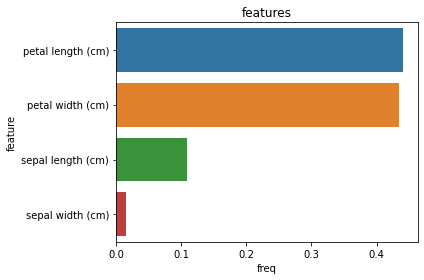

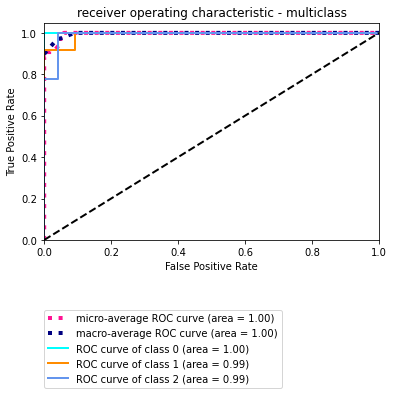

In [12]:
# run the function pointing the input and output paths to the NFS volume
train_run = run_local(None, train, 
                      params={"sample"          : -1, 
                              "label_column"    : "label",
                              "test_size"       : 0.10,
                              'model_pkg_class': "sklearn.ensemble.RandomForestClassifier"},
                      inputs={"dataset": 'https://s3.wasabisys.com/iguazio/data/iris/iris_dataset.csv'})

### Check the run results

In [16]:
train_run.outputs

{'accuracy': 0.9117647058823529,
 'test-error': 0.08823529411764706,
 'auc-micro': 0.9954584775086505,
 'auc-weighted': 0.9949732620320856,
 'f1-score': 0.9011764705882354,
 'precision_score': 0.907051282051282,
 'recall_score': 0.898148148148148,
 'test_set': 'store://default/sklearn-classifier-train_model_test_set#4be223546a5b44f3a0afd365d7c08c92',
 'confusion-matrix': '/home/jovyan/data/model/plots/confusion-matrix.html',
 'feature-importances': '/home/jovyan/data/model/plots/feature-importances.html',
 'precision-recall-multiclass': '/home/jovyan/data/model/plots/precision-recall-multiclass.html',
 'roc-multiclass': '/home/jovyan/data/model/plots/roc-multiclass.html',
 'model': 'store://default/sklearn-classifier-train_model_model#4be223546a5b44f3a0afd365d7c08c92'}

## Run model validation job against the new model

In [19]:
validate = import_function('hub://test_classifier')

> 2020-11-16 00:57:33,568 [info] starting run test-classifier-test_classifier uid=61389a64bfd149afa5eaf3851e0019a1 DB=http://localhost:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...0019a1,0,Nov 16 00:57:33,completed,test-classifier-test_classifier,kind=owner=jovyanhost=8a47298fe0fe,models_pathtest_set,label_column=label,accuracy=0.9333333333333333test-error=0.06666666666666667auc-micro=0.9755555555555555auc-weighted=0.9944444444444444f1-score=0.9137254901960784precision_score=0.8888888888888888recall_score=0.9629629629629629,confusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclasstest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run 61389a64bfd149afa5eaf3851e0019a1 --project default , !mlrun logs 61389a64bfd149afa5eaf3851e0019a1 --project default
> 2020-11-16 00:57:34,442 [info] run executed, status=completed


<Figure size 432x288 with 0 Axes>

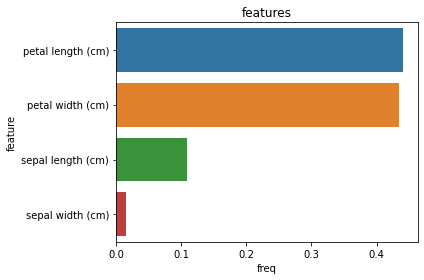

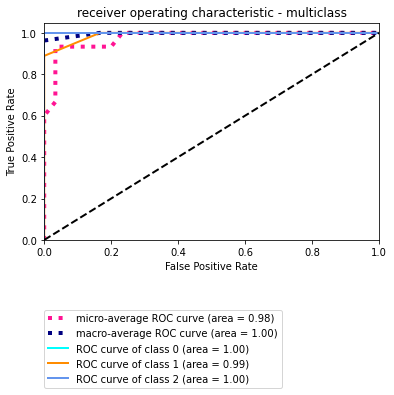

In [22]:
run_local(None, validate, params={'label_column': 'label'}, 
          inputs={"models_path" : train_run.outputs['model'],
                  "test_set"    : train_run.outputs['test_set']})